In [273]:
import pandas as pd
import numpy as np

import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRFRegressor
from tqdm.auto import tqdm

from itertools import product

from functions.graph_with_prediction import graph_with_prediction


In [240]:
train_data = pd.read_csv('../../data/preprocessed_data/train_year_oil_rate_5_days_ago_without_gaps.csv')
train_data.sort_values(by='MEASURED_IN_DATE', inplace=True)
train_data['MEASURED_IN_DATE'] = pd.to_datetime(train_data['MEASURED_IN_DATE'])
train_data.set_index('MEASURED_IN_DATE', inplace=True)


train_data_one_well = train_data[train_data['WELL_NAME'] == 1]

X = train_data_one_well.iloc[:, : -1]
y = train_data_one_well['TARGET_OIL_RATE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

X_train.head()

,WELL_NAME,OIL_RATE_5_days_ago,OIL_RATE_4_days_ago,OIL_RATE_3_days_ago,OIL_RATE_2_days_ago,OIL_RATE_1_days_ago
MEASURED_IN_DATE,,,,,,
2020-09-05,1,98.80,97.60,99.63,96.40,91.20
2020-09-06,1,97.60,99.63,96.40,91.20,90.82
2020-09-07,1,99.63,96.40,91.20,90.82,92.82
2020-09-08,1,96.40,91.20,90.82,92.82,96.76
2020-09-09,1,91.20,90.82,92.82,96.76,96.76


In [264]:
params = {'n_estimators': range(10, 1000, 100),
          'max_depth': range(1, 20, 3),
          'max_leaves': range(1, 20, 3),
          'learning_rate': [3 * 10 ** -4, 0.1, 0.3, 0.6, 0.7]}

param_values = list(params.values())
combinations = list(product(*param_values))

best_score = np.inf
best_params = None 

for comb in tqdm(combinations, desc='Processing'):

    model = XGBRFRegressor(n_estimators=comb[0], max_depth=comb[1], max_leaves=comb[2], learning_rate=comb[3], n_jobs=-1)
    model.fit(X_train, y_train)
    
    
    data = X_test.iloc[[0]]

    total_point = X_test.shape[0]
    count_days_ago = data.shape[1] - 1

    answer = []

    for i in range(total_point):

        value_point = float(model.predict(data))

        answer.append(value_point)

        data.iloc[0 , - count_days_ago : - 1] = data.iloc[0 , - count_days_ago + 1 : ]
        data.iloc[0 , - 1] = value_point

    answer = pd.Series(answer, index=y_test.index)
    
    
    score = mean_absolute_error(y_test, answer)
    
    if score < best_score:
        best_score = score
        best_params = comb
    pbar.update()

Processing: 100%|██████████████████████████████████████████████████████████████████| 2450/2450 [20:40<00:00,  1.97it/s]


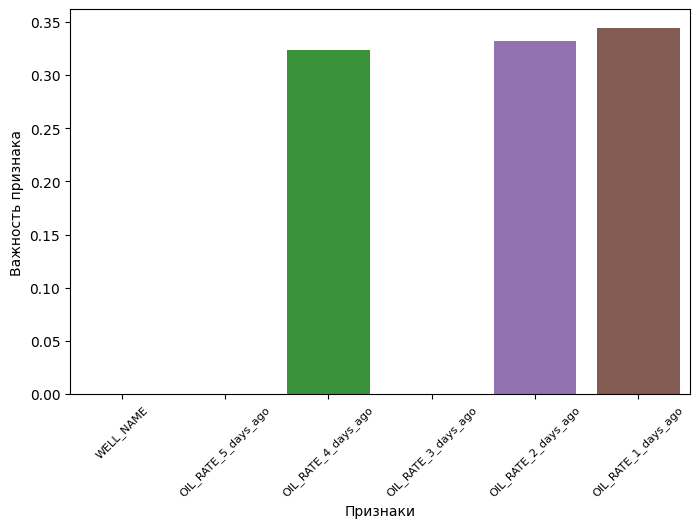

In [282]:
best_params
model = XGBRFRegressor(n_estimators=best_params[0], 
                       max_depth=best_params[1], 
                       max_leaves=best_params[2], 
                       learning_rate=best_params[3])
model.fit(X_train, y_train)
importances = model.feature_importances_


fig, axes = plt.subplots(figsize=(8,5))
sns.barplot(x=X_train.columns, y=importances);
axes.set_ylabel('Важность признака')
axes.set_xlabel('Признаки')
x_ticklabels = axes.get_xticklabels()
for label in x_ticklabels:
    label.set_rotation(45)
    label.set_fontsize(8)

In [268]:
data = X_test.iloc[[0]]

total_point = X_test.shape[0]
count_days_ago = data.shape[1] - 1

answer = []

for i in range(total_point):
    
    value_point = float(model.predict(data))
    
    
    answer.append(value_point)
        
    data.iloc[0 , - count_days_ago : - 1] = data.iloc[0 , - count_days_ago + 1 : ]
    data.iloc[0 , - 1] = value_point

answer = pd.Series(answer, index=y_test.index)

In [269]:
graph_with_prediction(y_train=y_train, y_test=y_test, answer_model=answer, model_name='Xgboost')